In [5]:
! pip install --user --quiet torch

In [211]:
import torch
import random
import numpy as np
from torch import nn
from sklearn.metrics import mean_squared_error

In [212]:
from torch import nn
import torch.nn.functional as F

# def _pool_coefs(betas, weights):
#     D = betas.shape[0]
#     S = torch.matmul(betas.T, weights)
#     return S.repeat(D)

class LinearTransfer(torch.nn.Module):
    def __init__(self, P, alpha):
        # shape is (number of contexts, P)
        super().__init__()
        self.model = nn.Linear(P, 1, bias=False)
        self.alpha = alpha

    def forward(self, X):
        return self.model(X)

    def evaluate(self, X, taus):
        tau_hat = self.forward(X).flatten()

        cross_exp = ((taus * tau_hat)).mean()
        penalty = (tau_hat**2).mean()

        reg = self.alpha*(self.model.weight).abs().sum()
        # reg = 0

        loss = -2*cross_exp + penalty + reg
        return loss

In [213]:
from torch.utils.data import IterableDataset, Dataset

# def expand_data(x, i, num_classes):
#     D = num_classes - 1
#     if i > D:
#         raise Exception('index out of range for num_classes')

#     P = x.shape[0]
#     left = i*P
#     right = (D - i)*P
#     return F.pad(x, (left, right))

# def prep_data(dat, num_classes):
#     return torch.stack([expand_data(torch.tensor(x, dtype=torch.float32), idx, num_classes) 
#                         for x,idx in dat])

# class TransferData(IterableDataset):
#     def __init__(self, X, contexts):
#         self.dat = zip(X, contexts)
#         self.num_contexts = np.unique(contexts).shape[0]

#     def __iter__(self):
#         return iter(prep_data(self.dat, self.num_contexts))

class TransferData(Dataset):
    def __init__(self, dat):
        self.dat = [(torch.tensor(x, dtype=torch.float32), torch.tensor(t, dtype=torch.float32)) for x,t in dat]

    def __getitem__(self, i):
        return self.dat[i]

    def __len__(self):
        return len(self.dat)

In [214]:
from sklearn.linear_model import LinearRegression

def est_y(X, y):
    m = LinearRegression(fit_intercept=False)
    m.fit(X, y)
    return m


def format_data(y, treatment, context_idx, X):
    ids = np.unique(context_idx)
    # models = {i: est_y(X[context_idx==i], y[context_idx == i]) for i in ids}
    # return [(xx, models[ii].predict(xx.reshape(1, -1))) for yy,tt,ii,xx in zip(y, treatment, context_idx, X) if tt == 1]

    means = {i: np.mean(y[(context_idx == i) & (treatment == 0)]) for i in ids}
    return [(xx, yy - means[ii]) for yy,tt,ii,xx in zip(y, treatment, context_idx, X) if tt == 1]


In [217]:
from simulation import generate_data, split_out_dat


from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

def train(net, opt, ds):
    epochs = 100
    prev_loss = 0
    for i in range(epochs):
        data = DataLoader(ds, batch_size=100, shuffle=True)
        epoch_loss = 0
        for j,batch in enumerate(data):
            X, t = batch
            loss = net.evaluate(X, t)
            epoch_loss += loss
            loss.backward()
            opt.step()
            opt.zero_grad()

        if (epoch_loss - prev_loss).abs() < 0.1:
            break
        prev_loss = epoch_loss

    print(net.model.weight)

def lasso(ys_source, treatment, ds):
    y = ys_source[treatment == 1]
    X = np.array([x.numpy() for x,_ in ds])

    mm = ElasticNet(alpha = .9, l1_ratio = 1.)
    mm.fit(X, y)
    return mm

def fit_models(phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target):
    ds = TransferData(format_data(ys_source, treatment, context_idxs, phi_source))
    net = LinearTransfer(2, 2.0)
    opt = Adam(net.parameters(), lr=0.001)
    train(net, opt, ds)

    baseline = lasso(ys_source, treatment, ds)

    b_preds = phi_target.dot(baseline.coef_)
    t_preds = net(torch.tensor(phi_target, dtype=torch.float32)).reshape(-1).detach().numpy()

    return (mean_squared_error(taus_target, t_preds), mean_squared_error(taus_target, b_preds)), (t_preds, b_preds), (net, baseline), (phi_source, phi_target, taus_source, taus_target, context_idxs)


In [221]:
def fn(h, v, z, w):
    val = -w*h + 0.5*w*z + np.random.normal(0, 0.25, size = h.shape[0])
    return val

v_conds = [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)]
# v_conds = [(-0.5,0,1), (1,0,1), (0.5,0,1), (-1,2,1)]
# v_conds = [(1,0,1)]*4
hiddens = [(0,2)]*4
z_conds = [(2,2), (4,2), (6,2), (0,2)]

def runrun(N):
    dat = generate_data(N,
                    fn, 
                    hidden_cause = True, 
                    plot = False, 
                    hiddens = hiddens,
                    v_conds = v_conds, 
                    z_conds = z_conds)

    return fit_models(*split_out_dat(dat))

In [244]:
scores, preds, models, datt = runrun(1000)

ts, bs = scores
(ts - bs)/bs

Parameter containing:
tensor([[-0.0039,  0.4227]], requires_grad=True)


-0.20425977643087503

-0.11952450835693613


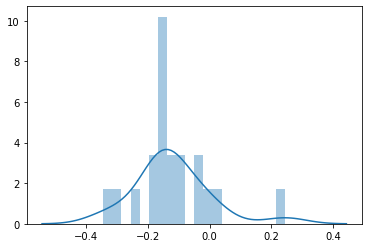

In [239]:
from joblib import Parallel, delayed
import seaborn as sns

results = Parallel(n_jobs=-1)(delayed(runrun)(1000) for i in range(20))
mse = [(t-c)/c for (t,c),_,(tt, ct),_ in results]
print(np.mean(mse))
sns.distplot(np.array(mse), bins = 20)

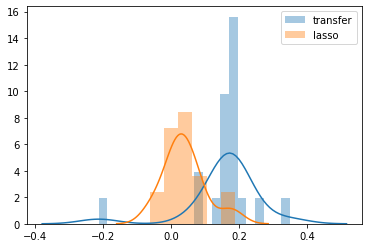

In [243]:
import matplotlib.pyplot as plt

tau_var = [np.mean((np.mean(txx) - txx)**2) for _,_,_,(_,_,_,txx,_) in results]
t_mse, c_mse = zip(*[(t,c) for (t,c),_,(tt, ct),_ in results])
for lbl,d in zip(['transfer', 'lasso'], [[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]):
    sns.distplot(d, label=lbl)
plt.legend()